<a href="https://colab.research.google.com/github/bodhivani/RAVEfold/blob/main/heavydemo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np

!git clone https://github.com/bodhivani/RAVEfold

!cp RAVEfold/ravefuncs.py .
import ravefuncs as rave

In [ ]:
#@title Install condacolab
#@markdown After running this cell wait for the kernel to restart (~1min)

#@markdown Then, start running the rest of the blocks
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

In [ ]:
#@title Install ColabFold and OpenMM with Plumed
#@markdown Run this to install and import libraries 
import time
t1 = time.perf_counter()
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj openmm cudatoolkit=11.2 openmmforcefields openmm-plumed 
    
    # for gromacs forcefield files (for conversion from GMX)
    %cd /content/Plumed-on-OpenMM-GPU/
    !tar -zxvf gromacsff.tar.gz
    %cp -r CSP_reqFiles /content/test_MD
    %cd /content/test_MD
    
    on_colab = True
    clear_output()             # clear the excessive installation outputs (disable incase of error check)
    print("Dependencies successfully installed and imported!")
except ModuleNotFoundError:
    on_colab = False

!pwd

# required for simulation with Plumed on gpu
from sys import stdout
from openmmplumed import PlumedForce
from openmm.app import *
from openmm import *
from openmm.unit import *

# required for analysis
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

t2 = time.perf_counter()
print('time taken to run:',t2-t1)

#create the directory for colabfold
from IPython.display import clear_output
!mkdir Colabfold_lowmsa
%cd /content/Colabfold_lowmsa/.
clear_output()

# setup device
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import sys
import tensorflow as tf
import jax

try:
  # check if TPU is available
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Running on TPU')
  DEVICE = "tpu"
except:
  if jax.local_devices()[0].platform == 'cpu':
    print("WARNING: no GPU detected, will be using CPU")
    DEVICE = "cpu"
  else:
    print('Running on GPU')
    DEVICE = "gpu"
    # disable GPU on tensorflow
    tf.config.set_visible_devices([], 'GPU')

from IPython.utils import io
import subprocess
import tqdm.notebook


install_jackhmmer = True      #not required

#AF2 repo from deepmind
GIT_REPO = 'https://github.com/deepmind/alphafold'
#AF2 params
SOURCE_URL = 'https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar'

PARAMS_DIR = './alphafold/data/params'
PARAMS_PATH = os.path.join(PARAMS_DIR, os.path.basename(SOURCE_URL))

TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)

#tqdm specification
TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'
# if not already installed
total = 55
with tqdm.notebook.tqdm(total=total, bar_format=TQDM_BAR_FORMAT) as pbar:
  if not os.path.isdir("alphafold"):
    # download alphafold code and clone colabfold repo
    os.system(f"git clone {GIT_REPO} alphafold; cd alphafold; git checkout 1d43aaff941c84dc56311076b58795797e49107b")
    os.system(f"git clone https://github.com/sokrypton/ColabFold.git")

    # apply patches
    os.system(f"patch -u alphafold/alphafold/model/model.py -i ColabFold/beta/model.patch")
    os.system(f"patch -u alphafold/alphafold/model/mapping.py -i ColabFold/beta/mapping.patch")
    os.system(f"patch -u alphafold/alphafold/model/modules.py -i ColabFold/beta/modules.patch")
    os.system(f"patch -u alphafold/alphafold/model/folding.py -i ColabFold/beta/folding.patch")
    os.system(f"patch -u alphafold/alphafold/model/config.py -i ColabFold/beta/config.patch")
    # apply multi-chain patch from Lim Heo @huhlim
    os.system(f"patch -u alphafold/alphafold/common/protein.py -i ColabFold/beta/protein.patch")
    pbar.update(4)

    #install biopython
    os.system(f"pip install biopython dm-haiku==0.0.5 ml-collections py3Dmol")
    pbar.update(6)

    # download model params (speedup from kaczmarj)
    os.system(f"mkdir --parents {PARAMS_DIR}")
    os.system(f"curl -fsSL {SOURCE_URL} | tar x -C {PARAMS_DIR}")
    pbar.update(14+27)

    # install hhsuite
    os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C {TMP_DIR}/")

    # install jackhmmer   #not required and will remove it
    if install_jackhmmer:
      os.system(f"sudo apt install --quiet --yes hmmer")
      pbar.update(3)

      # create a ramdisk to store a database chunk to make Jackhmmer run fast.
      os.system(f"sudo mkdir -m 777 --parents /tmp/ramdisk")
      os.system(f"sudo mount -t tmpfs -o size=9G ramdisk /tmp/ramdisk")
      pbar.update(1)

    else:
      pbar.update(4)

  else:
    pbar.update(55)

###############################################################################################
####    Python imports 
###############################################################################################
if 'alphafold' not in sys.path:
  sys.path.append('alphafold')
if 'ColabFold/beta' not in sys.path:
  sys.path.append('ColabFold/beta')

if f"{TMP_DIR}/bin" not in os.environ['PATH']:
  os.environ['PATH'] += f":{TMP_DIR}/bin:{TMP_DIR}/scripts"

import colabfold as cf
import colabfold_alphafold as cf_af

import json
import matplotlib.pyplot as plt
import numpy as np

try:
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False


In [ ]:
#@title Run Colabfold with reduced MSA
#Code was taken from COLABFOLD git and modified for convenience 
import re
import time
from IPython.display import clear_output
#####################################################################################################################
###    Input sequence
#####################################################################################################################

sequence = 'MQRGKVKWFNNEKGYGFIEVEGGSDVFVHFTAIQGEGFKTLEEGQEVSFEIVQGNRGPQAANVVKE' #@param {type:"string"}
jobname = "CSP" #@param {type:"string"}
homooligomer =  "1" #param {type:"string"}


#####################################################################################################################
###    MSA parameters
#####################################################################################################################


add_custom_msa = False 
msa_format = "fas" 
pair_mode = "unpaired" 
pair_cov = 50 
pair_qid = 20 

I = cf_af.prep_inputs(sequence, jobname, homooligomer, clean=IN_COLAB)
msa_method = "mmseqs2" 
#I['output_dir']='_'.join(I['output_dir'].split('_')[:-1])
I = cf_af.prep_msa(I, msa_method, add_custom_msa, msa_format,
                   pair_mode, pair_cov, pair_qid, TMP_DIR=TMP_DIR)
mod_I = I
clear_output() # ----> Clear the output from previous functions
#No relaxation 
num_relax = "None"


#####################################################################################################################
###    Parameters for running Alphafold
#####################################################################################################################
rank_by = "pLDDT" 
use_turbo = True 
max_msa = "08:16" #@param ["512:1024", "256:512", "128:256", "64:128", "32:64","16:32","08:16","04:08","02:04","01:02","02:02"]
#@markdown - `max_msa` defines: `max_msa_clusters:max_extra_msa` number of sequences to use. 
max_msa_clusters, max_extra_msa = [int(x) for x in max_msa.split(":")]

show_images = False 

num_models = 5 
use_ptm = True 
num_ensemble = 1 
max_recycles = 1 
is_training = True 
num_samples = 128 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
#@markdown - `num_samples` defines the number of random seed. (For each seed 5 different models are predicted)  
subsample_msa = True 

if not use_ptm and rank_by == "pTMscore":
  print("WARNING: models will be ranked by pLDDT, 'use_ptm' is needed to compute pTMscore")
  rank_by = "pLDDT"

# prep input features
feature_dict = cf_af.prep_feats(mod_I, clean=IN_COLAB)
Ls_plot = feature_dict["Ls"]

# prep model options
opt = {"N":len(feature_dict["msa"]),
       "L":len(feature_dict["residue_index"]),
       "use_ptm":use_ptm,
       "use_turbo":use_turbo,
       "max_recycles":max_recycles,
       "tol":0.0,
       "num_ensemble":num_ensemble,
       "max_msa_clusters":max_msa_clusters,
       "max_extra_msa":max_extra_msa,
       "is_training":is_training}

if use_turbo:
  if "runner" in dir():
    # only recompile if options changed
    runner = cf_af.prep_model_runner(opt, old_runner=runner)
  else:
    runner = cf_af.prep_model_runner(opt)
else:
  runner = None

#####################################################################################################################
###    Run Alphafold with low MSA 
#####################################################################################################################
t1 = time.perf_counter()
outs, model_rank = cf_af.run_alphafold(feature_dict, opt, runner, num_models, num_samples, subsample_msa,
                                       rank_by=rank_by, show_images=show_images)



#####################################################################################################################
###    Output folder
#####################################################################################################################

structures_path='/content/Structures'   #Output_folder
os.makedirs(structures_path)
file_path=os.path.join(structures_path,'file_details.txt')
with open(file_path, "w") as file_details:
  for n,key in enumerate(model_rank):
    copy_line=f'cp {I["output_dir"]}/rank_{n+1}_{key}_unrelaxed.pdb {structures_path}/pred_{n+1}.pdb'
    os.system(copy_line)
    if num_relax !="None":
      if n<num_relax: 
        copy_line2=f'cp {I["output_dir"]}/rank_{n+1}_{key}_relaxed.pdb {structures_path}/pred_{n+1}.pdb'
        os.system(copy_line2)
    line = f"pred_{n+1}.pdb pLDDT:{outs[key]['pLDDT']:.2f}" + f" pTMscore:{outs[key]['pTMscore']:.4f}" if use_ptm else ""
    file_details.write(line+"\n")

#os.system(f'rm -r {I[output_dir]}')   #--> run this line to delete the second copy of structures
%cd /content/
os.system(f'zip -FSr Structures.zip {structures_path}')
t2 = time.perf_counter()
clear_output()
print('\nTime taken to generate:',(t2-t1)/60,' mins')

print(f'The structures can be found in {structures_path}')

In [ ]:
#@title Cluster to initialize RAVEfold

rave.RegSpaceClustering()

In [ ]:
#@markdown Here we are using already solvated and equilibrated system(from GMX)

# Inputs definition 

#@markdown Check the below box to run on GPU
on_gpu=True #@param {type:"boolean"}
#@markdown MD parameters

#@markdown Integration Timestep (ps)
dt =0.002 #@param{type:"number"}
#@markdown Temperature (K)
temp=300 #@param{type:"number"}
#@markdown frequency of interaction with the bath (1/ps)
freq=1 #param{type:"number"}
#@markdown Number of steps 
nstep=500000 #@param{type:"number"}
#@markdown 

run_unbiased(on_gpu,dt,temp,freq,nstep,index)

In [ ]:
for i,j in enumerate(indices):
    np.save("traj_%i_unb.npy"%j,np.hstack([np.sin(cvs[i]),np.cos(cvs[i])]))
    np.save("chis_%i_unb.npy"%j,cvs[i])
    lentraj=len(cvs[i])
    zeroone=np.hstack([np.zeros(int(lentraj/2),dtype=np.int8),np.ones(lentraj-int(lentraj/2),dtype=np.int8)])
    initlabels=np.eye(num_state)[zeroone+int(i*2)]
    np.save("labels_%i_unb.npy"%i,initlabels)

/content/test_MD


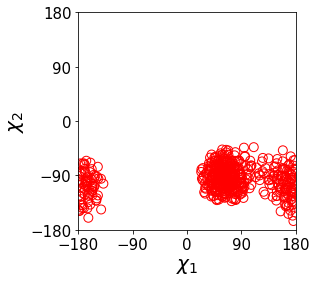

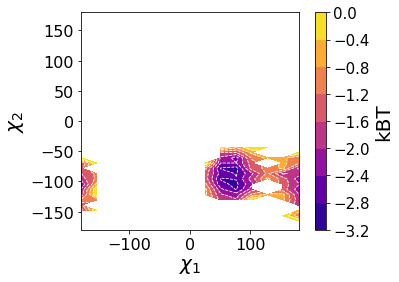

In [ ]:
#@title Analysis Plot chi1 vs chi2 of Trp8
#@markdown free energy plot (without reweighting on the biased CVs)
fes_nrw=True #@param {type:"boolean"}
%cd /content/test_MD/


traj = md.load_dcd('output_gpu_plm.dcd', top='reference.pdb')
Chivals=np.zeros((2,len(traj)))
for ind, tr in enumerate(traj):
  #print('step : ',ind)
  ta1,tb1=md.compute_chi1(tr);
  ta2,tb2=md.compute_chi2(tr);
  Chivals[0,ind]=tb1[0][6];
  Chivals[1,ind]=tb2[0][5];
  #Chival2[ind]=tb2[0][5];

Chivals=Chivals*(180/np.pi)
left=-180;
right=180;


plt.figure(1);
plt.gca().set_aspect('equal')
plt.scatter(Chivals[0,:], Chivals[1,:],s=80,facecolors='none',edgecolors='r')
plt.xlabel(r'$\chi_1$',fontsize=20);
plt.ylabel(r'$\chi_2$',fontsize=20);
plt.xlim([left,right]);
plt.ylim([left,right]);
plt.xticks([-180,-90,0,90,180],fontsize=15);
plt.yticks([-180,-90,0,90,180],fontsize=15);
plt.show();

if fes_nrw:
  numpy.seterr(divide = 'ignore')
  hist,xv,yv=np.histogram2d(Chivals[0,:],Chivals[1,:],bins=15)
  ln_hist=-np.log(hist)
  plt.figure(2)
  plt.gca().set_aspect('equal')
  plt.contourf(ln_hist.transpose(),extent=[xv[0],xv[-1],yv[0],yv[-1]],cmap=plt.cm.plasma)
  cbar=plt.colorbar()
  plt.contour(ln_hist.transpose(),extent=[xv[0],xv[-1],yv[0],yv[-1]],colors='white',linewidths=0.8)
  plt.xlabel(r'$\chi_1$',fontsize=20);
  plt.ylabel(r'$\chi_2$',fontsize=20);
  plt.xticks(fontsize=16);
  plt.yticks(fontsize=16);
  plt.xlim([left,right]);
  plt.ylim([left,right]);
  cbar.set_label('kBT',fontsize=20)
  cbar.ax.tick_params(labelsize=15)